This project aims to predict used car listing prices in a dataset that was scraped from a German listing Website in February-March 2016. The method used is Decision Tree Regressor. The project compares the baseline DecisionTreeRegressor from scikit-learn library to the a Decision Tree Regresson implemented from scratch. The from-scratch implementation is overall comparable to the scikit-learn implementaion in terms of performance. The project uses various metrics to estimate the performance, but the main metric considered is r^2-score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import ttest_rel

## Pre-processing

In [2]:
df = pd.read_csv('autos.csv', encoding='ISO-8859-1')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.shape

(371528, 20)

In [4]:
# removing dates and dropping duplicate entries
df = df.drop(labels = ['dateCrawled', 'dateCreated', 'lastSeen'], axis = 1)
df = df.drop_duplicates()
df.shape

(367148, 17)

In [5]:
# removing the rest of unnecessary labels
df = df.drop(labels = ['name', 'powerPS', 'offerType' ,'abtest', 'model', 'monthOfRegistration', 'nrOfPictures', 'postalCode'], axis = 1)
df.columns

Index(['seller', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [6]:
df.isnull().sum()

seller                    0
price                     0
vehicleType           37613
yearOfRegistration        0
gearbox               19946
kilometer                 0
fuelType              33208
brand                     0
notRepairedDamage     71256
dtype: int64

### Removing scammy listings
Some listings may have prices that are way too high or way too low; some suspicious listing put in kilometerage (mileage) that is unreasonably high or low. Also, the registration (production year) of the car may be listed as a year before cars were even manufactured, or as a year in future. I am going to remove those listings because they are untrustworthy and don't represent the actual price dynamics. 
#### Checking the prices

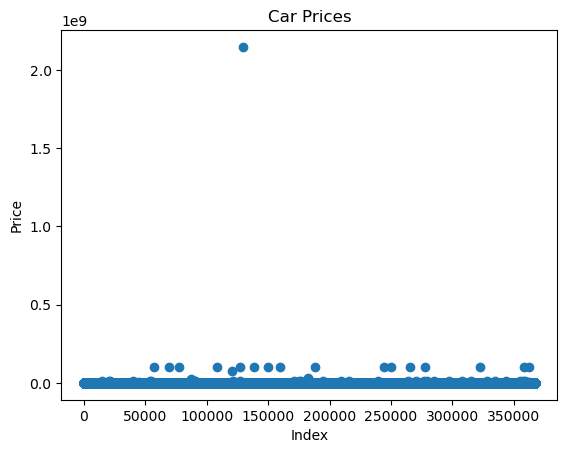

In [7]:
plt.scatter(range(len(df)), df['price'])
plt.title('Car Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

Assuming that used cars will cost under 100,000 euros

In [8]:
# only leaving listings with the price less than 100,000
df = df[df['price'] < 100000]

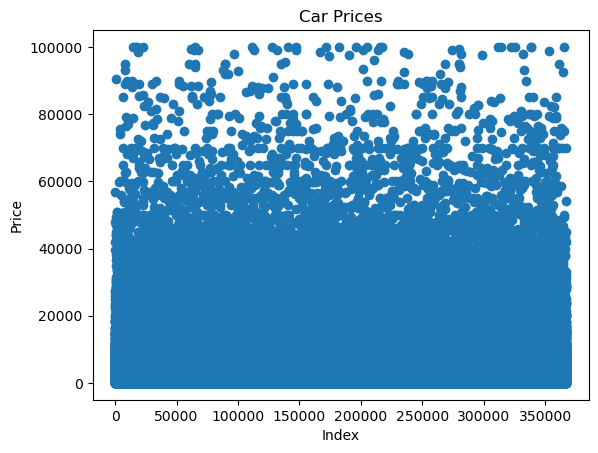

In [9]:
plt.scatter(range(len(df)), df['price'])
plt.title('Car Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

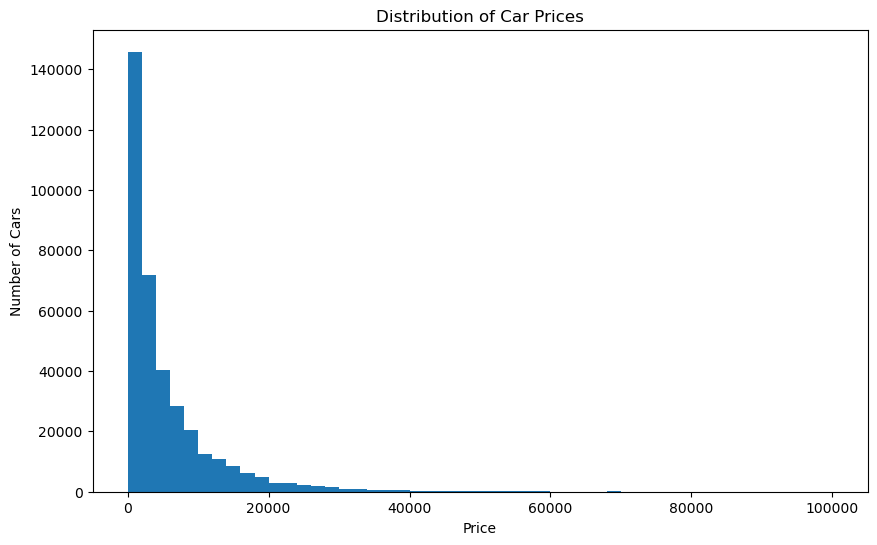

In [10]:
df['price'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')
plt.show()

In [11]:
# only leaving listings with the price greater than 300 euros and less than 30,000 euros
df = df[(df['price'] > 300) & (df['price'] < 30000)]
df.shape

(335571, 9)

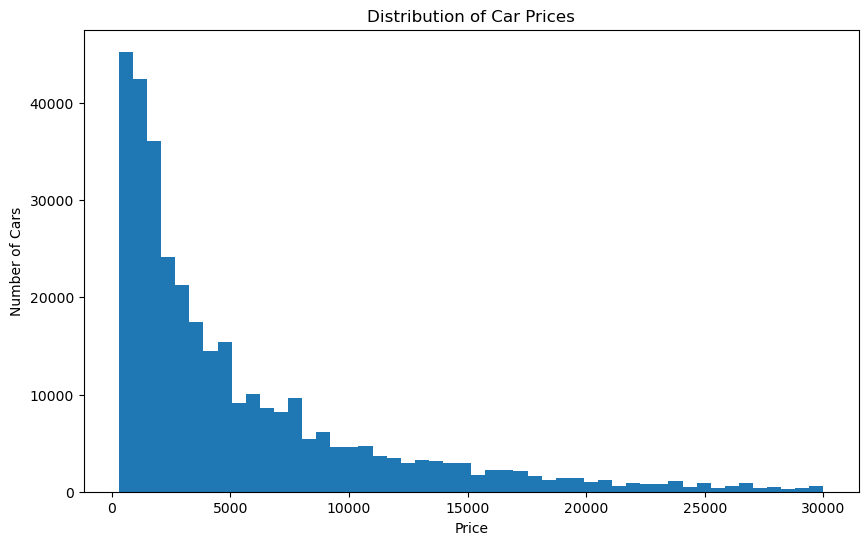

In [12]:
df['price'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')
plt.show()

Now the price distribution looks more realistic

#### Checking the kilometerage

In [13]:
df['kilometer'].value_counts().sort_index()

kilometer
5000        4414
10000       1395
20000       4511
30000       5092
40000       5614
50000       6906
60000       7937
70000       9035
80000      10251
90000      11618
100000     14466
125000     35542
150000    218790
Name: count, dtype: int64

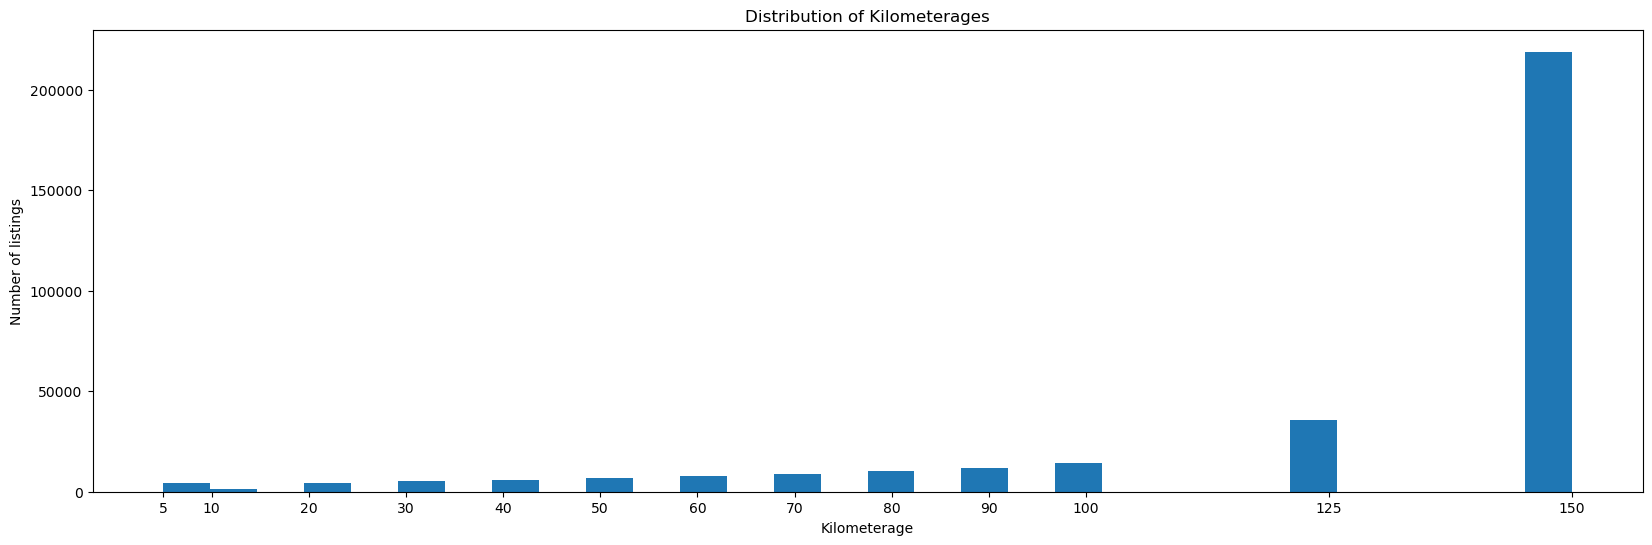

In [14]:
plt.figure(figsize=(20, 6))
plt.hist(df['kilometer'], bins=30)
plt.title('Distribution of Kilometerages')
plt.xlabel('Kilometerage')
plt.ylabel('Number of listings')
ticks = [5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]
tick_labels = [str(int(tick/1000)) for tick in ticks]
plt.xticks(ticks, tick_labels)
plt.show()

We can see that there are more listings with 5000 kilometers (3.1k miles) than with 10000 kilometers, which is suspicious. Therefore, I will drop all listings for cars older than 3 years that list that they only have 5000 kilometers.

In [15]:
df.drop(df[(df['kilometer'] == 5000) & (df['yearOfRegistration'] < 2013)].index, inplace=True)
df.shape

(332342, 9)

Similarly, there seems to be too many cars with 150,000 kilometers (93.2k miles). I will drop all cars with 150,000 kilometers that are 3 years old or newer.

In [16]:
df.drop(df[(df['kilometer'] == 150000) & (df['yearOfRegistration'] >= 2013)].index, inplace=True)
df.shape

(316342, 9)

### Checking the date range

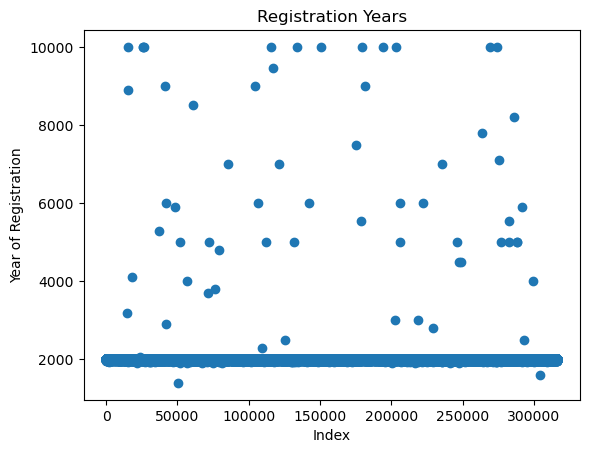

In [17]:
plt.scatter(range(len(df)), df['yearOfRegistration'])
plt.title('Registration Years')
plt.xlabel('Index')
plt.ylabel('Year of Registration')
plt.show()

In [18]:
df['yearOfRegistration'].min()

1400

#### Estimating the valid date range

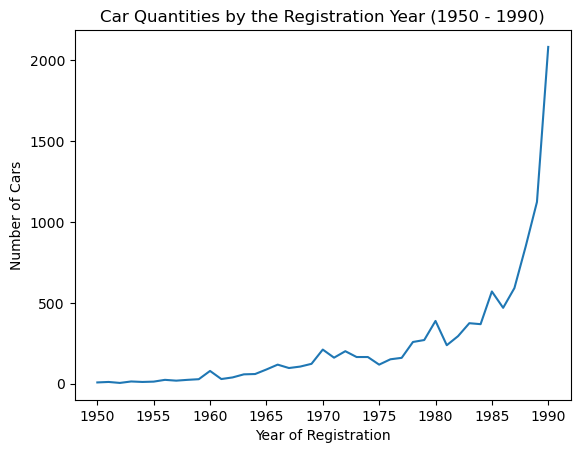

In [19]:
# estimating the earliest reasonable date
newdf = df[(df['yearOfRegistration'] >= 1950) & (df['yearOfRegistration']<=1990)]
values = (newdf['yearOfRegistration'].value_counts().sort_index())
values.plot()
plt.title('Car Quantities by the Registration Year (1950 - 1990)')
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.show()

According to this graph, the earliest reasonable date seems to be in late 1950s. Therefore, I will assume the valid year range to be 1956 - 2016 (the dataset was created in 2016).

#### Removing the listings that have the year of registration before 1956 and after 2016


In [20]:
df = df[(df['yearOfRegistration'] >= 1956)&(df['yearOfRegistration']<=2016)]
df.shape

(312541, 9)

### Translating entries from German

In [21]:
df['seller'].unique()

array(['privat', 'gewerblich'], dtype=object)

In [22]:
df['seller'].replace('privat','private',inplace = True)
df['seller'].replace('gewerblich','commercial',inplace = True)

In [23]:
df['vehicleType'].unique()

array([nan, 'coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus',
       'kombi', 'andere'], dtype=object)

In [24]:
df['vehicleType'].replace(np.nan,'type_unspecified',inplace=True)
df['vehicleType'].replace('kleinwagen','subcompact',inplace = True)
df['vehicleType'].replace('bus','minivan',inplace = True)
df['vehicleType'].replace('kombi','hatchback',inplace = True)
df['vehicleType'].replace('andere','other',inplace = True)

In [25]:
df['gearbox'].unique()

array(['manuell', 'automatik', nan], dtype=object)

In [26]:
df['gearbox'].replace(np.nan,'gear_unspecified',inplace=True)
df['gearbox'].replace('manuell','manual',inplace = True)
df['gearbox'].replace('automatik','automatic',inplace = True)

In [27]:
df['fuelType'].unique()

array(['benzin', 'diesel', nan, 'lpg', 'andere', 'hybrid', 'cng',
       'elektro'], dtype=object)

In [28]:
df['fuelType'].replace(np.nan,'fuel_unspecified',inplace=True)
df['fuelType'].replace('benzin','gasoline',inplace = True)
df['fuelType'].replace('andere','other',inplace = True)
df['fuelType'].replace('elektro','electric',inplace = True)

In [29]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'suzuki', 'lancia', 'porsche',
       'citroen', 'toyota', 'kia', 'chevrolet', 'dacia', 'sonstige_autos',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

In [30]:
df['notRepairedDamage'].unique()

array([nan, 'ja', 'nein'], dtype=object)

In [31]:
df['notRepairedDamage'].replace(np.nan,'damage_unspecified',inplace=True)
df['notRepairedDamage'].replace('ja','yes',inplace = True)
df['notRepairedDamage'].replace('nein','no',inplace = True)

In [32]:
df.isnull().sum()

seller                0
price                 0
vehicleType           0
yearOfRegistration    0
gearbox               0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
dtype: int64

In [33]:
df.head()

,seller,price,vehicleType,yearOfRegistration,gearbox,kilometer,fuelType,brand,notRepairedDamage
0,private,480,type_unspecified,1993,manual,150000,gasoline,volkswagen,damage_unspecified
1,private,18300,coupe,2011,manual,125000,diesel,audi,yes
2,private,9800,suv,2004,automatic,125000,diesel,jeep,damage_unspecified
3,private,1500,subcompact,2001,manual,150000,gasoline,volkswagen,no
4,private,3600,subcompact,2008,manual,90000,diesel,skoda,no


### Replacing categorical values with dummies

In [34]:
seller = pd.get_dummies(df['seller'])
v_type = pd.get_dummies(df['vehicleType'])
gearbox = pd.get_dummies(df['gearbox'])
fuel = pd.get_dummies(df['fuelType'])
brand = pd.get_dummies(df['brand'])
damage = pd.get_dummies(df['notRepairedDamage'])
df = pd.concat([df, seller, v_type, gearbox, fuel, brand, damage], axis = 1)
df = df.drop(labels = ['seller', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage' ], axis = 1)

In [35]:
df.head()

,price,yearOfRegistration,kilometer,commercial,private,cabrio,coupe,hatchback,limousine,minivan,...,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,damage_unspecified,no,yes
0,480,1993,150000,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,18300,2011,125000,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,9800,2004,125000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1500,2001,150000,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
4,3600,2008,90000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Checking the average listing price in the dataset, for future references

In [36]:
df['price'].mean()

5541.068659791836

## Processing

### Splitting the dataset

In [37]:
# randomly shuffling the dataset
df = df.sample(frac=1).reset_index(drop=True)

# splitting the features and the labels, converting them to NumPy
X = df.drop('price', axis=1).to_numpy()
y = df['price'].to_numpy()

# splitting the dataset into test (20%), validation (15%), and training (65%)
test_size = int(0.20 * len(df))
val_size = int(0.15 * len(df))
train_size = len(df) - val_size - test_size

# first 20% goes to testing
X_test = X[:test_size]
y_test = y[:test_size]

# next 15% goes to validation
X_val = X[test_size:test_size + val_size]
y_val = y[test_size:test_size + val_size]

# the rest goes to training
X_train = X[test_size + val_size:]
y_train = y[test_size + val_size:]

### Getting performance estimates

In [38]:
def get_estimates(y_, y_pred_):
    # computing MAE, rounded to a whole number
    mae = int(round(np.mean(np.abs(y_ - y_pred_)), 0))

    # computing MedAE, rounded to a whole number
    medae = int(round(np.median(np.abs(y_ - y_pred_)), 0))

    # computing R^2, rounded to two decimals
    ss_res = np.sum((y_ - y_pred_) ** 2)
    ss_tot = np.sum((y_ - np.mean(y_)) ** 2)
    r2 = round(1 - (ss_res / ss_tot), 2)

    # computing Mean, MSE, and Standard Deviation, rounded to whole numbers
    mean_pred = int(round(np.mean(y_pred_), 0))
    mse = int(round(np.mean((y_ - y_pred_) ** 2), 0))
    std_dev = int(round(np.sqrt(np.mean((y_pred_ - mean_pred) ** 2)), 0))


    # Printing the results
    print(f'Mean Squared Error (MSE): {mse:>10}'
          f'\nMean Absolute Error (MAE): {mae:>9}'
          f'\nMedian Absolute Error (MedAE): {medae:>5}'
          f'\nMean: {mean_pred:>30}' 
          f'\nStandard Deviation: {std_dev:>16}'
          f'\nR^2 Score: {r2:>25}')

## Decision Tree with r^2-score

In [39]:
def r2_score(y_true, y_pred):
    # computing the r^2-score
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    # to prevent dividing by zero
    if np.isclose(ss_tot, 0):
        return 0 if ss_res != 0 else 1
    return 1 - ss_res / ss_tot

def split(X_, y_, ind_, thresh_):
    # splitting the dataset into left and right subsets
    ml = X_[:, ind_] <= thresh_ # less than or equal than threshold goes to the left
    mr = X_[:, ind_] > thresh_ # greater than threshold goes to the right
    return X_[ml], X_[mr], y_[ml], y_[mr]

def get_best_r2_split(X_, y_):
# finding the best split based on the r^2-score
    best_feat, best_thresh, best_r2, best_splits = None, None, float("-inf"), None
    for ind in range(X_.shape[1]):
        # finding all unqiue values to use as potential thresholds
        thresholds = np.unique(X_[:, ind])
        for t in thresholds:
            # splitting the data based on the threshold
            X_l, X_r, y_l, y_r = split(X_, y_, ind, t)
            if len(y_l) > 0 and len(y_r) > 0:
                # predicted values are the mean of the target values
                y_l_pred = np.mean(y_l)
                y_r_pred = np.mean(y_r)

                # computing the average r^2-score for the split
                current_r2 = (((len(y_l)*r2_score(y_l, np.full(len(y_l), y_l_pred))) +
                                 (len(y_r)*r2_score(y_r, np.full(len(y_r), y_r_pred))))/(len(y_)))

                # if the r^2-score is better, updating the values
                if current_r2 > best_r2:
                    best_r2 = current_r2
                    best_feat = ind
                    best_thresh = t
                    best_splits = (X_l, X_r, y_l, y_r)
    return best_feat, best_thresh, best_splits

In [40]:
# tree node class for the Decision Tree
class Node:
    def __init__(self, feat_ind_=None, thresh_=None, l_=None, r_=None, val_=None):
        self.feat_ind = feat_ind_ # features used for splitting at this node
        self.thresh = thresh_ # threshold for splitting the node
        self.l = l_ # left child
        self.r = r_ # right child
        self.val = val_ # value, if a leaf node

In [41]:
class R2DecisionTreeRegressor:
    def __init__(self, max_depth_=10):
        self.root = None
        self.max_depth = max_depth_

    def fit(self, X_, y_):
        self.root = self._build_tree(X_, y_)
        return self
    
    def _build_tree(self, X_, y_, depth_=0):
    # recursively building a decision tree
        if depth_ < self.max_depth and len(np.unique(y_)) > 1:
            # finding the best split, if the depth allows
            feat_ind, thresh, splits = get_best_r2_split(X_, y_)
            if splits:
            # if a valid split is found, splitting the node further    
                X_l, X_r, y_l, y_r = splits
                n_l = self._build_tree(X_l, y_l, depth_ + 1)
                n_r = self._build_tree(X_r, y_r, depth_ + 1)
                return Node(feat_ind, thresh, n_l, n_r)
                # returning a non-terminal node
        return Node(val_=np.mean(y_))
        # otherwise, returning a leaf node
  
    def predict(self, X_):
    # taking an array of inputs, calling private _predict method to get their output
        return np.array([self._predict(input, self.root) for input in X_])

    def _predict(self, inp_, node_):
    # making a prediction for a single input sample
        if node_.val is not None:
        # if a leaf node, returning the prediction    
            return node_.val
        # otherwise, recursively calling _predict on child nodes
        if inp_[node_.feat_ind] <= node_.thresh:
            return self._predict(inp_, node_.l)
        else:
            return self._predict(inp_, node_.r)

In [42]:
model1 = R2DecisionTreeRegressor()
model1.fit(X_train, y_train)
y_val_pred1 = model1.predict(X_val)
get_estimates(y_val, y_val_pred1)

Mean Squared Error (MSE):   33953779
Mean Absolute Error (MAE):      4350
Median Absolute Error (MedAE):  3718
Mean:                           5523
Standard Deviation:              224
R^2 Score:                      -0.0


Using r^2-score as the splitting criterion does not seem to be succesful. Therefore, I am going to implement the Decision Tree with MSE as the splitting criterion.

## Decision Tree with MSE

In [43]:
def mse_score(y):
    return np.mean((y - np.mean(y)) ** 2)

def get_best_mse_split(X, y):
# finding the best split based on MSE
    best_feat, best_thresh, best_mse, best_splits = None, None, float("inf"), None
    for ind in range(X.shape[1]):
        # finding all unqiue values to use as potential thresholds
        thresholds = np.unique(X[:, ind])
        for t in thresholds:
            # splitting the data based on the threshold
            X_l, X_r, y_l, y_r = split(X, y, ind, t)
            if len(y_l) > 0 and len(y_r) > 0:
                # computing MSE for left and right subsets, adding them up
                current_mse = len(y_l) / len(y) * mse_score(y_l) + len(y_r) / len(y) * mse_score(y_r)
                if current_mse < best_mse:
                    best_mse = current_mse
                    best_feat = ind
                    best_thresh = t
                    best_splits = (X_l, X_r, y_l, y_r)
    return best_feat, best_thresh, best_splits

In [44]:
class MSEDecisionTreeRegressor:
    def __init__(self, max_depth_=10):
        self.root = None
        self.max_depth = max_depth_

    def fit(self, X, y):
        self.root = self._build_tree(X, y)
        return self
    
    def _build_tree(self, X_, y_, depth_=0):
    # recursively building a decision tree
        if depth_ < self.max_depth and len(np.unique(y_)) > 1:
        # finding the best split, if the depth allows
            feat_ind, thresh, splits = get_best_mse_split(X_, y_)
            if splits:
            # if a valid split is found, splitting the node further    
                X_l, X_r, y_l, y_r = splits
                n_l = self._build_tree(X_l, y_l, depth_ + 1)
                n_r = self._build_tree(X_r, y_r, depth_ + 1)
                return Node(feat_ind, thresh, n_l, n_r)
                # returning a non-terminal node
        return Node(val_=np.mean(y_))
        # otherwise, returning a leaf node

    def predict(self, X_):
    # taking an array of inputs, calling private _predict method to get their output
        return np.array([self._predict(i, self.root) for i in X_])

    def _predict(self, inp_, node_):
    # making a prediction for a single input sample
        if node_.val is not None:
        # if a leaf node, returning the prediction    
            return node_.val
        # otherwise, recursively calling _predict on child nodes
        if inp_[node_.feat_ind] <= node_.thresh:            
            return self._predict(inp_, node_.l)
        else:
            return self._predict(inp_, node_.r)

In [45]:
model2 = MSEDecisionTreeRegressor()
model2.fit(X_train, y_train)
y_val_pred2 = model2.predict(X_val)
get_estimates(y_val, y_val_pred2)

Mean Squared Error (MSE):    8538284
Mean Absolute Error (MAE):      1820
Median Absolute Error (MedAE):  1073
Mean:                           5560
Standard Deviation:             5017
R^2 Score:                      0.75


As we can see, using MSE as the splitting criterion results in a good prediction result.

## Parameter Tuning

The only parameter I was planning to change was the number of features. Using PCA and SVD for dimensionality reduction resulted in datasets that had too many unique values for each variable. Since the from-scratch model uses unique values as thresholds, having an overwhelming number of those unique values made the model excruciatingly slow. Therefore, the only viable way to reduce the number of dimensions is to simply drop the ones that have the least variance.

In [46]:
def reduce_dimensions(n, X_train_, X_val_, X_test_):
    # calculating the variance of each feature
    variances = np.var(X_train_, axis=0)

    # sort features by variance (descending)
    indices = np.argsort(variances)[::-1]

    # select the first n features
    top_n_indices = indices[:n]

    X_train_red_ = X_train_[:, top_n_indices]
    X_val_red_ = X_val_[:, top_n_indices]
    X_test_red_ = X_test_[:, top_n_indices]

    return X_train_red_, X_val_red_, X_test_red_

#### Finding the optimal number of features

In [47]:
mses = []
maes = []
medaes = []
r2s = []
comp_range = range(30, 68)
for n in comp_range:
    # applying dimensionality reduction
    X_train_red, X_val_red, X_test_red = reduce_dimensions(n, X_train, X_val, X_test)

    model3 = MSEDecisionTreeRegressor()
    model3.fit(X_train_red, y_train)
    y_val_pred3 = model3.predict(X_val_red)
    
    # computing MSE, rounded to a whole number
    mse = int(round(np.mean((y_val - y_val_pred3) ** 2),0))
    mses.append(mse)

    # computing r^2, rounded to two decimals
    ss_res = np.sum((y_val - y_val_pred3) ** 2)
    ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
    r2 = round(1 - (ss_res / ss_tot), 2)
    r2s.append(r2)

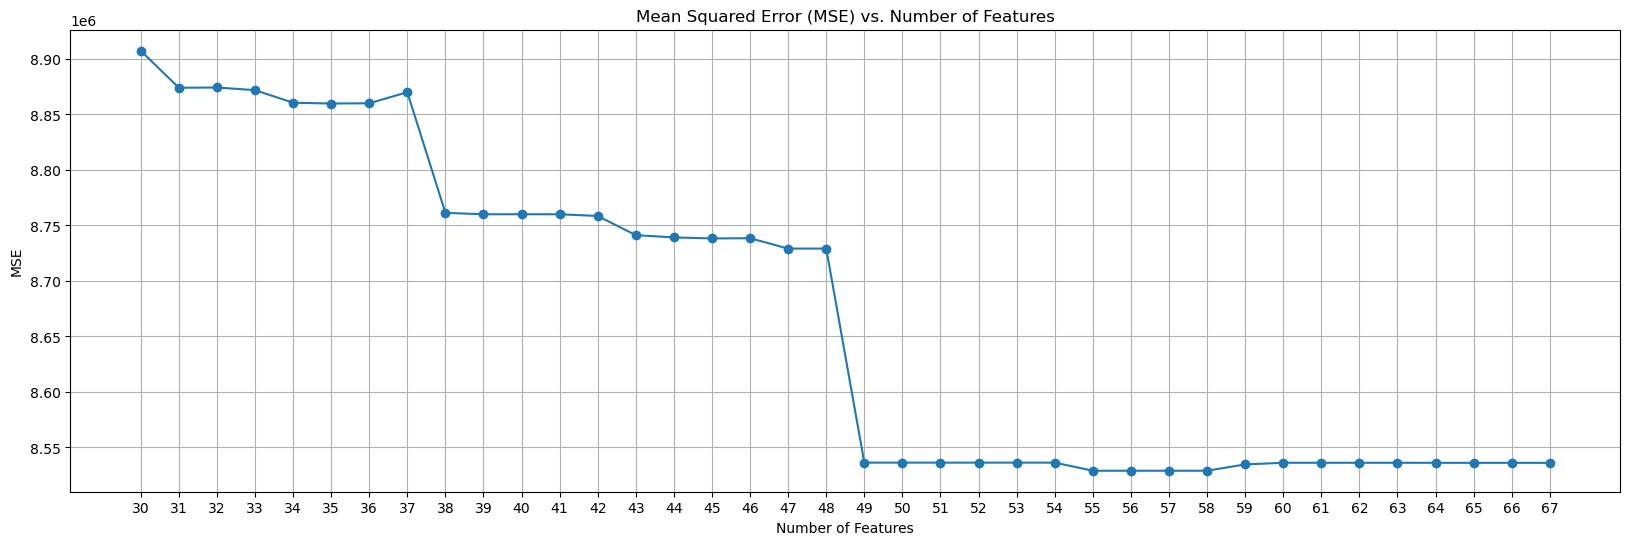

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, mses, marker='o')
plt.title('Mean Squared Error (MSE) vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

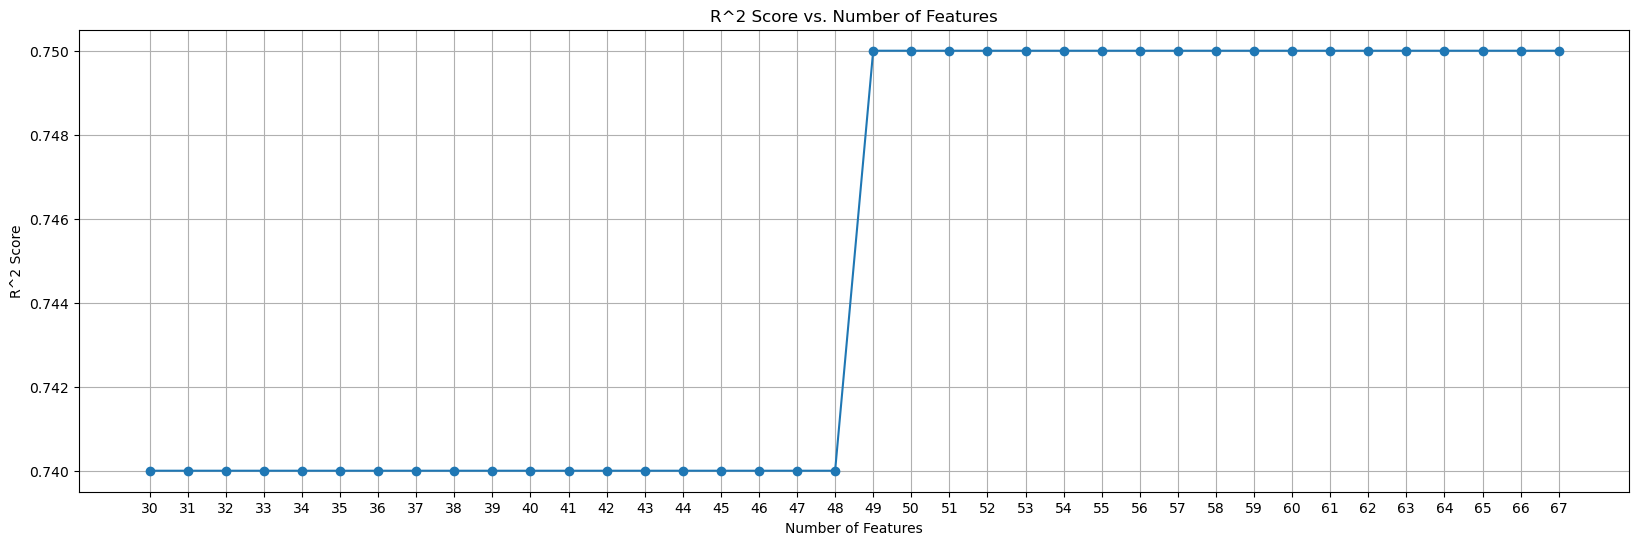

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, r2s, marker='o')
plt.title('R^2 Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

We see a sharp decline in MSE and a sharp rise in r^2-score at 49 features. Therefore, 49 is the optimal number of features.

In [50]:
# applying dimensionality reduction to limit the dataset to 49 features
opt_n = 49
X_train_red, X_val_red, X_test_red = reduce_dimensions(opt_n, X_train, X_val, X_test)

## Comparing the Models
### The sci-kit Model

In [51]:
model4 = DecisionTreeRegressor()
model4.fit(X_train_red, y_train)
y_pred4 = model4.predict(X_test_red)
get_estimates(y_test, y_pred4)

Mean Squared Error (MSE):    7647931
Mean Absolute Error (MAE):      1569
Median Absolute Error (MedAE):   782
Mean:                           5561
Standard Deviation:             5485
R^2 Score:                      0.77


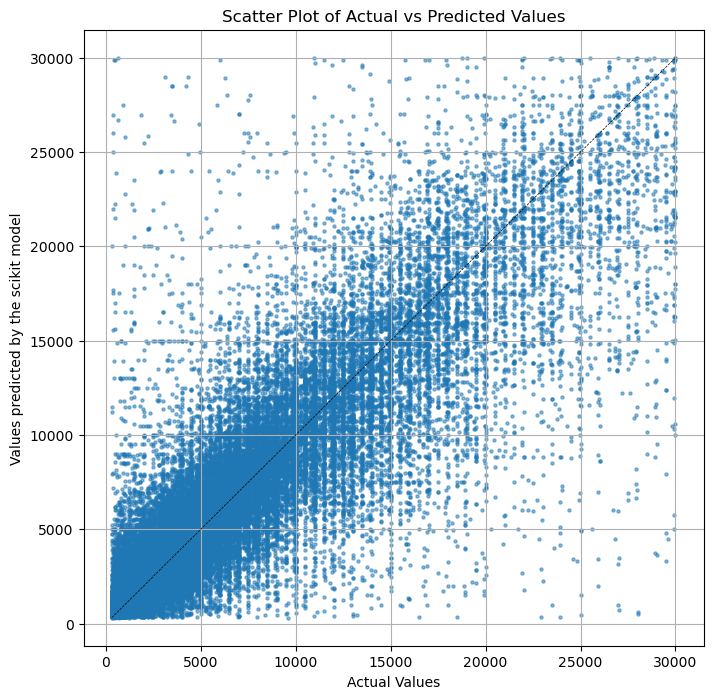

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred4, alpha=0.5, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=0.5)  # diagonal line

plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Values predicted by the scikit model')
plt.grid(True)
plt.show()

### The From-scratch Model

In [53]:
model5 = MSEDecisionTreeRegressor()
model5.fit(X_train_red, y_train)
y_pred5 = model5.predict(X_test_red)
get_estimates(y_test, y_pred5)

Mean Squared Error (MSE):    8132334
Mean Absolute Error (MAE):      1789
Median Absolute Error (MedAE):  1066
Mean:                           5534
Standard Deviation:             4999
R^2 Score:                      0.75


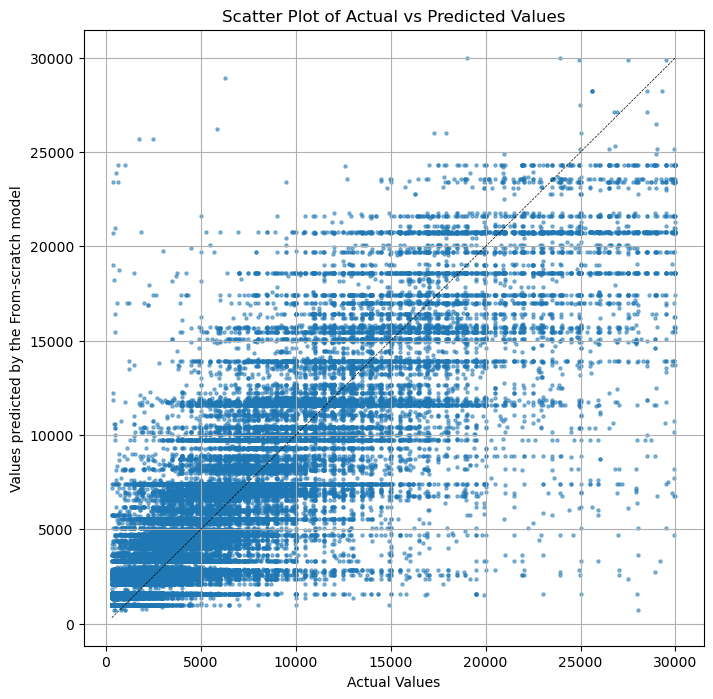

In [54]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred5, alpha=0.5, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=0.5)  # diagonal line

plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Values predicted by the From-scratch model')
plt.grid(True)
plt.show()

## The Difference in Performance

In [55]:
t_stat, p_val = ttest_rel(y_pred4, y_pred5)
print(f'\nT-stat: {t_stat:.4f}'
      f'\nP-value: {p_val:.4f}')
if p_val < 0.05:
    print(f'\nThe difference is statistically significant')
else:
    print(f'\nThe difference is not statistically significant')


T-stat: 3.0247
P-value: 0.0025

The difference is statistically significant


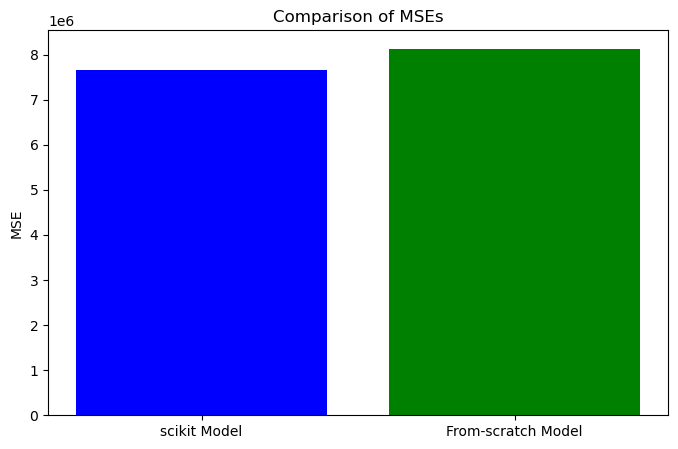

In [56]:
# calculating MSEs
# computing MSE for y_pred4
mse1 = np.mean((y_test - y_pred4) ** 2)

# computing MSE for y_pred5
mse2 = np.mean((y_test - y_pred5) ** 2)

# Plotting MSE for y_pred4 and y_pred5
plt.figure(figsize=(8, 5))
plt.bar(['scikit Model', 'From-scratch Model'], [mse1, mse2], color=['blue', 'green'])
plt.title('Comparison of MSEs')
plt.ylabel('MSE')
plt.show()

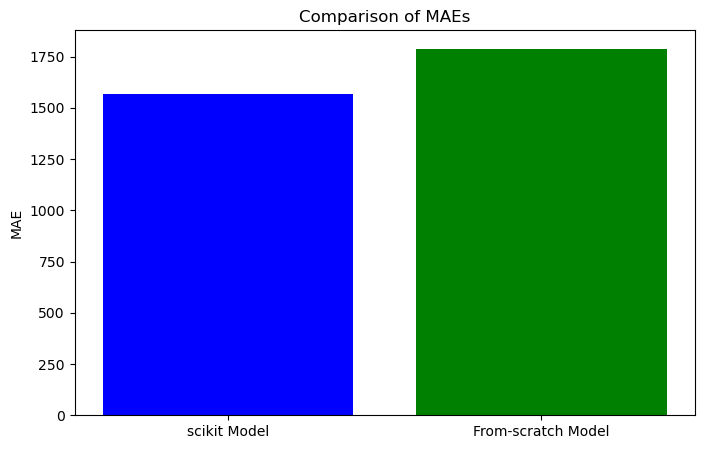

In [57]:
# calculating MAEs
# computing MAE for y_pred4
mae1 = np.mean(np.abs(y_test - y_pred4))

# computing MAE for y_pred5
mae2 = np.mean(np.abs(y_test - y_pred5))

# Plotting MAE scores for y_pred4 and y_pred5
plt.figure(figsize=(8, 5))
plt.bar(['scikit Model', 'From-scratch Model'], [mae1, mae2], color=['blue', 'green'])
plt.title('Comparison of MAEs')
plt.ylabel('MAE')
plt.show()

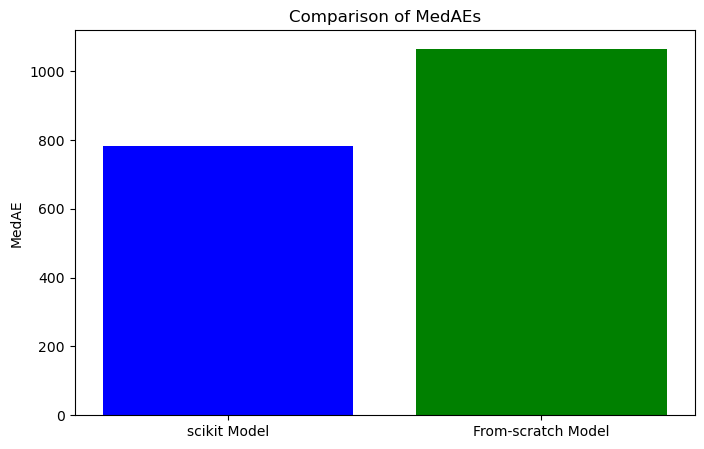

In [58]:
# calculating MedAEs
# computing MedAE for y_pred4
medae1 = np.median(np.abs(y_test - y_pred4))

# computing MedAE for y_pred5
medae2 = np.median(np.abs(y_test - y_pred5))

# Plotting MedAE scores for y_pred4 and y_pred5
plt.figure(figsize=(8, 5))
plt.bar(['scikit Model', 'From-scratch Model'], [medae1, medae2], color=['blue', 'green'])
plt.title('Comparison of MedAEs')
plt.ylabel('MedAE')
plt.show()

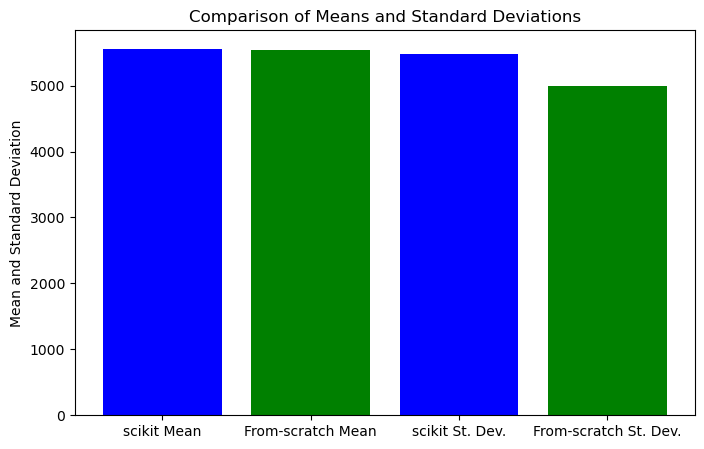

In [59]:
# calculating mean and standard deviation
# for y_pred4
mean_pred1 = np.mean(y_pred4)
std_dev1 = np.sqrt(np.mean((y_pred4 - mean_pred1) ** 2))

# for y_pred5
mean_pred2 = np.mean(y_pred5)
std_dev2 = np.sqrt(np.mean((y_pred5 - mean_pred2) ** 2))

# Plotting mean and stdev for y_pred4 and y_pred5
plt.figure(figsize=(8, 5))
plt.bar(['scikit Mean', 'From-scratch Mean', 'scikit St. Dev.', 'From-scratch St. Dev.'], [mean_pred1, mean_pred2, std_dev1, std_dev2], color=['blue', 'green', 'blue', 'green'])
plt.title('Comparison of Means and Standard Deviations')
plt.ylabel('Mean and Standard Deviation')
plt.show()

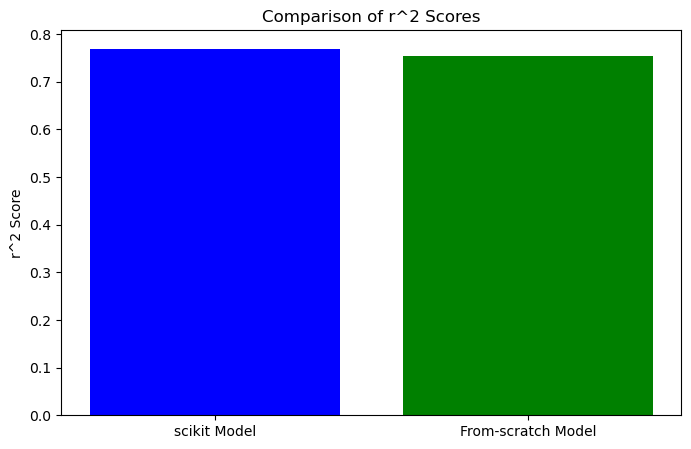

In [60]:
# calculating r^2 scores
# computing r^2 for y_pred4
ss_res = np.sum((y_test - y_pred4) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_1 = 1 - (ss_res / ss_tot)

# computing r^2 for y_pred5
ss_res = np.sum((y_test - y_pred5) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_2 = 1 - (ss_res / ss_tot)

# Plotting r^2 scores for y_pred4 and y_pred5
plt.figure(figsize=(8, 5))
plt.bar(['scikit Model', 'From-scratch Model'], [r2_1, r2_2], color=['blue', 'green'])
plt.title('Comparison of r^2 Scores')
plt.ylabel('r^2 Score')
plt.show()

The scikit model slightly outperforms the from-scratch model in terms of MSE, MAE, and MedAE, which indicates its better overall prediction accuracy.
The r^2-scores are relatively close, but the scikit model is slightly ahead.
The means of predictions are quite similar for both models, but the scikit model has a higher standard deviation, indicating more variability in its predictions.
The t-test results (T-stat: 3.0247, P-value: 0.0025) suggest that the differences in predictions between the two models are statistically significant, with the scikit model having a higher performance.
While both models show comparable performance, the scikit model has a slight edge in most metrics and its superiority is statistically significant. Looking at the scatter plots of actual vs. predicted values, we can see that the scikit model's ponits are evenly dispersed, whereas the from-scratch model's points look stratified, which indicates that the from-scratch model has more rigid splitting criteria, hence the lower variability.